In [20]:
%run util_draw.py
%matplotlib inline
import matplotlib as mpl
from matplotlib import pyplot as plt
from array import array
import rootpy as rpy
import rootpy.plotting.root2matplotlib as rplt
from rootpy.io import root_open
import numpy as np
import pandas as pd
import math
import ROOT
from root_numpy import root2array, root2rec, tree2rec

In [21]:
E1F_E0 = 5.497
E16_E0 = 5.754
MP = 0.93827203
ME = 0.000511
MPIX = 0.139
MPI0 = 0.135
MOMEGA = 0.78265

In [4]:
fn_r0, fn_r2 = '../e1f6/test/genev_e1f_rad_0.root', '../e1f6/test/genev_e1f_rad_2.root'
hQ2W_r0, hQ2W_r2 = None, None
sQ2 = '(2*%.3f*mcp[0]*(1-cos(TMath::DegToRad()*mctheta[0])))'%E1F_E0
sW = '(sqrt(%.3f*%.3f+2*%.3f*(%.3f-mcp[0])-%s))'%(MP,MP,MP,E1F_E0,sQ2)
with root_open(fn_r0) as fin:
    tr0 = asrootpy(fin.h10)
    hQ2W_r0 = tr0.Draw('%s:%s>>hQ2W_r0(80,1.6,3.2,35,0,7)'%(sW,sQ2), '', 'colz')
with root_open(fn_r2) as fin:
    tr2 = fin.h10
    hQ2W_r2 = tr2.Draw('%s:%s>>hQ2W_r2(80,1.6,3.2,35,0,7)'%(sW,sQ2), '', 'colz')

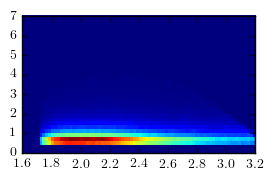

In [5]:
draw(hQ2W_r2)
plt.show()

In [6]:
hQ2W_r2.Divide(hQ2W_r0)

True

In [18]:
# bQ2_500 = hQ2W_r0.get_yaxis().FindBin(0.5)
# bQ2_1000 = hQ2W_r0.get_yaxis().FindBin(1.0)
# bQ2_1500 = hQ2W_r0.get_yaxis().FindBin(1.5)
# bQ2_2000 = hQ2W_r0.get_yaxis().FindBin(2.0)
# bQ2_2500 = hQ2W_r0.get_yaxis().FindBin(2.5)
# bQ2_3000 = hQ2W_r0.get_yaxis().FindBin(3.0)
# suffixes = ['_500_1000', '_1000_1500', '_1500_2000', '_2000_2500', '_2500_3000']
# b0b1s = [(bQ2_500, bQ2_1000), (bQ2_1000, bQ2_1500), (bQ2_1500, bQ2_2000),
#          (bQ2_2000, bQ2_2500), (bQ2_2500, bQ2_3000)]
# hWs = [hQ2W_r0.projection_x(suffix, b0, b1) for suffix, (b0,b1) in zip(suffixes, b0b1s)]
hWs = [hQ2W_r2.projection_x('_%d_%d'%(b0,b0), b0, b0) for b0 in [5]]

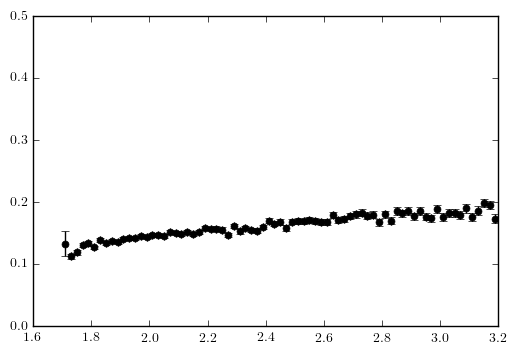

In [19]:
colors = ['k', 'b', 'r', 'g', 'y']
fig = plt.figure()
for i,hW in enumerate(hWs):
    draw(asrootpy(hW), fig=fig)
    plt.ylim(0,0.5)

In [3]:
# e0 = E1F_E0
# fn_r0, fn_r2 = '../e1f6/test/genev_e1f_rad_0.root', '../e1f6/test/genev_e1f_rad_2.root'
# df_r0, df_r2 = None, None

# with root_open(fn_r0) as fin:
#     df_r0 = pd.DataFrame(tree2rec(fin.h10, ['mcp[0]', 'mctheta[0]']))
#     df_r0.columns = ['p', 'theta']
# with root_open(fn_r2) as fin:
#     df_r2 = pd.DataFrame(tree2rec(fin.h10, ['mcp[0]', 'mctheta[0]']))
#     df_r2.columns = ['p', 'theta']

# def add_Q2W_to_df(df, e0):
#     df['Q2'] = 2*e0*df.p*(1-np.cos(np.deg2rad(df.theta)))
#     df['W'] = np.sqrt(MP**2+2*MP*(e0-df.p-df.Q2))

# add_Q2W_to_df(df_r0, e0)
# add_Q2W_to_df(df_r2, e0)



# hQ2W_r0 = np.histogram2d(df_r0.W, df_r0.Q2, bins=[np.arange(0,7,0.05), np.arange(1.5,3.2,0.02)])
# hQ2W_r2 = np.histogram2d(df_r2.W, df_r2.Q2, bins=[np.arange(0,7,0.05), np.arange(1.5,3.2,0.02)])

# im = plt.imshow(hQ2W_r0[0])
# plt.show()